Denoising Auto Encoder(DAE)

https://github.com/francis-kang/handson-unsupervised-learning/blob/master/08_autoencoders.ipynb

사기 데이터

In [2]:
## 라이브러리 불러오기
'''메인 라이브러리'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

'''시각화 관련 라이브러리'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''데이터 준비 및 모델 평가 관련 라이브러리'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

'''알고리즘 관련 라이브러리'''
import lightgbm as lgb

'''텐서플로 및 케라스 관련 라이브러리'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [3]:
data = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [4]:
dataX = data.copy().drop(['Class','Time', 'Amount'],axis=1)
dataY = data['Class'].copy()

In [5]:
# 데이터 스케일
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

In [6]:
# 훈련 및 테스트 셋으로 분할
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                     random_state=2018, stratify=dataY)

In [7]:
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

In [8]:
# 평가 함수(이상치 스코어 함수) 및 그래프 함수 정의

def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - \
                   np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [9]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'], \
                               preds['anomalyScore'])
    average_precision = average_precision_score( \
                        preds['trueLabel'], preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
        {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: Area under the \
        curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds, average_precision  ### diff

#DAE(Denoising Auto Encoder)

Epoch 1/10
5964/5964 [==============================] - 35s 5ms/step - loss: 0.1260 - accuracy: 0.8006 - val_loss: 0.0354 - val_accuracy: 0.8670
Epoch 2/10
5964/5964 [==============================] - 33s 6ms/step - loss: 0.0496 - accuracy: 0.8912 - val_loss: 0.0359 - val_accuracy: 0.9188
Epoch 3/10
5964/5964 [==============================] - 41s 7ms/step - loss: 0.0486 - accuracy: 0.8938 - val_loss: 0.0375 - val_accuracy: 0.9139
Epoch 4/10
5964/5964 [==============================] - 30s 5ms/step - loss: 0.0479 - accuracy: 0.9049 - val_loss: 0.0370 - val_accuracy: 0.9341
Epoch 5/10
5964/5964 [==============================] - 40s 7ms/step - loss: 0.0477 - accuracy: 0.9139 - val_loss: 0.0367 - val_accuracy: 0.9388
Epoch 6/10
5964/5964 [==============================] - 46s 8ms/step - loss: 0.0479 - accuracy: 0.9190 - val_loss: 0.0369 - val_accuracy: 0.9525
Epoch 7/10
5964/5964 [==============================] - 40s 7ms/step - loss: 0.0474 - accuracy: 0.9177 - val_loss: 0.0397 - val_ac

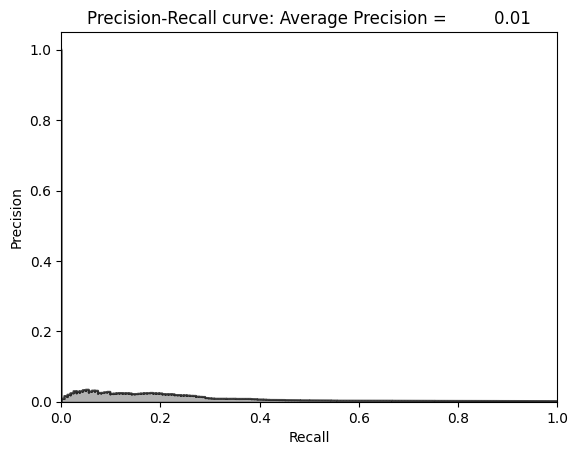

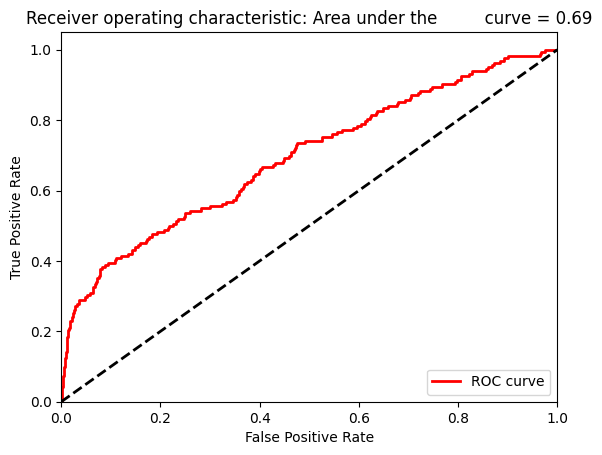

Epoch 1/10
5964/5964 [==============================] - 40s 7ms/step - loss: 0.1300 - accuracy: 0.7839 - val_loss: 0.0354 - val_accuracy: 0.8940
Epoch 2/10
5964/5964 [==============================] - 30s 5ms/step - loss: 0.0470 - accuracy: 0.8814 - val_loss: 0.0349 - val_accuracy: 0.9141
Epoch 3/10
5964/5964 [==============================] - 31s 5ms/step - loss: 0.0466 - accuracy: 0.9024 - val_loss: 0.0366 - val_accuracy: 0.9370
Epoch 4/10
5964/5964 [==============================] - 40s 7ms/step - loss: 0.0482 - accuracy: 0.9078 - val_loss: 0.0358 - val_accuracy: 0.9483
Epoch 5/10
5964/5964 [==============================] - 30s 5ms/step - loss: 0.0464 - accuracy: 0.9131 - val_loss: 0.0363 - val_accuracy: 0.9429
Epoch 6/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.0472 - accuracy: 0.9160 - val_loss: 0.0366 - val_accuracy: 0.9462
Epoch 7/10
5964/5964 [==============================] - 41s 7ms/step - loss: 0.0471 - accuracy: 0.9110 - val_loss: 0.0365 - val_ac

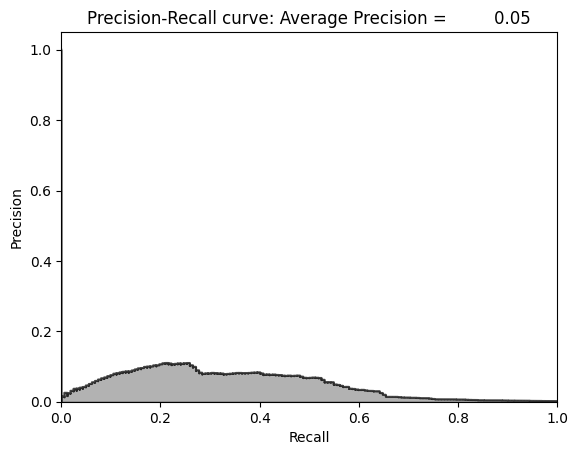

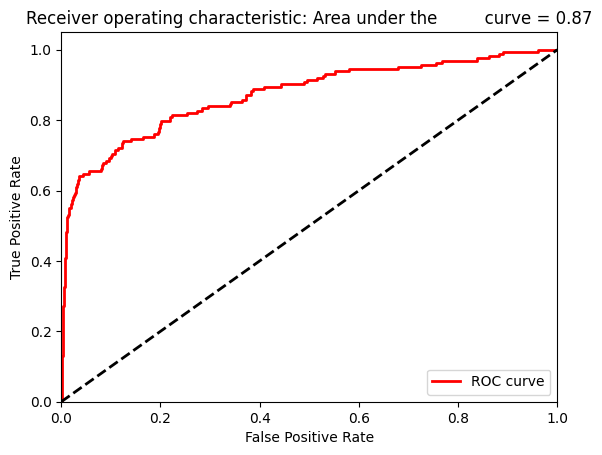

Epoch 1/10
5964/5964 [==============================] - 40s 7ms/step - loss: 0.1176 - accuracy: 0.8304 - val_loss: 0.0348 - val_accuracy: 0.9186
Epoch 2/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0464 - accuracy: 0.9062 - val_loss: 0.0348 - val_accuracy: 0.9371
Epoch 3/10
5964/5964 [==============================] - 41s 7ms/step - loss: 0.0448 - accuracy: 0.9095 - val_loss: 0.0341 - val_accuracy: 0.9320
Epoch 4/10
5964/5964 [==============================] - 40s 7ms/step - loss: 0.0452 - accuracy: 0.9088 - val_loss: 0.0339 - val_accuracy: 0.9418
Epoch 5/10
5964/5964 [==============================] - 31s 5ms/step - loss: 0.0440 - accuracy: 0.9113 - val_loss: 0.0364 - val_accuracy: 0.9186
Epoch 6/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0437 - accuracy: 0.9141 - val_loss: 0.0341 - val_accuracy: 0.9426
Epoch 7/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0447 - accuracy: 0.9126 - val_loss: 0.0336 - val_ac

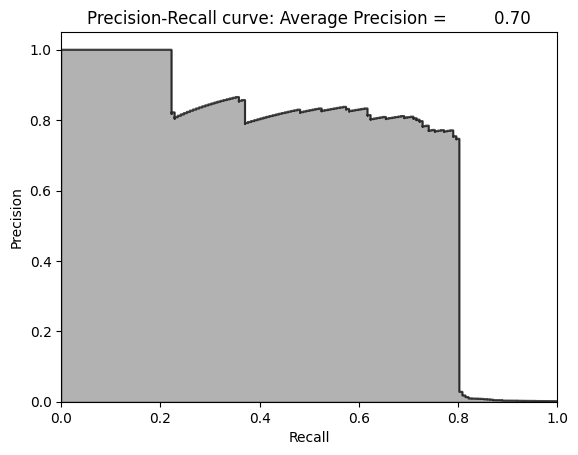

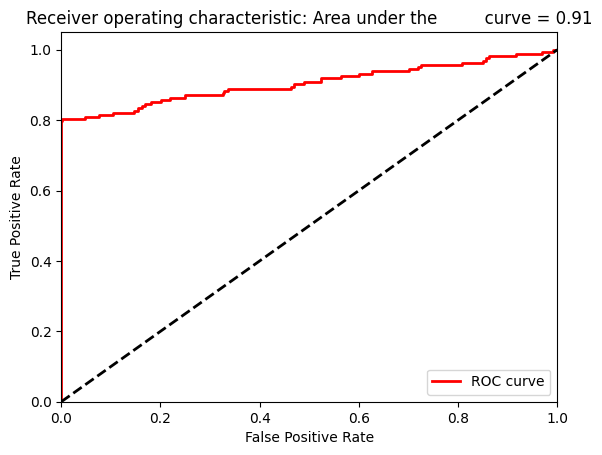

Epoch 1/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.1127 - accuracy: 0.8178 - val_loss: 0.0349 - val_accuracy: 0.9016
Epoch 2/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0500 - accuracy: 0.9132 - val_loss: 0.0373 - val_accuracy: 0.9478
Epoch 3/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.0477 - accuracy: 0.9183 - val_loss: 0.0373 - val_accuracy: 0.9554
Epoch 4/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.0480 - accuracy: 0.9156 - val_loss: 0.0367 - val_accuracy: 0.9425
Epoch 5/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0472 - accuracy: 0.9216 - val_loss: 0.0408 - val_accuracy: 0.9177
Epoch 6/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0476 - accuracy: 0.9090 - val_loss: 0.0368 - val_accuracy: 0.9395
Epoch 7/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0471 - accuracy: 0.9149 - val_loss: 0.0372 - val_ac

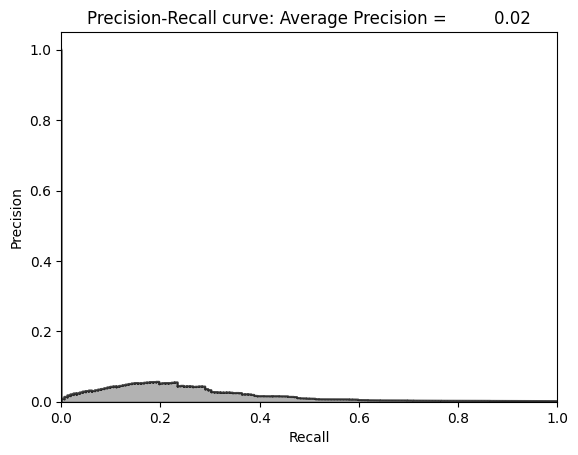

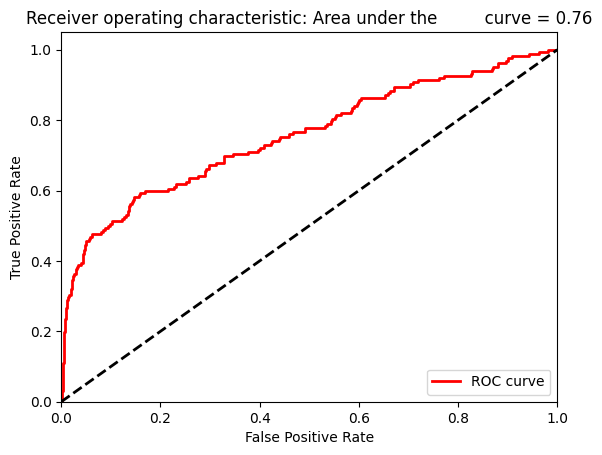

Epoch 1/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.1666 - accuracy: 0.7857 - val_loss: 0.0368 - val_accuracy: 0.8889
Epoch 2/10
5964/5964 [==============================] - 33s 6ms/step - loss: 0.0489 - accuracy: 0.8885 - val_loss: 0.0361 - val_accuracy: 0.9122
Epoch 3/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0481 - accuracy: 0.8927 - val_loss: 0.0361 - val_accuracy: 0.9177
Epoch 4/10
5964/5964 [==============================] - 41s 7ms/step - loss: 0.0479 - accuracy: 0.9088 - val_loss: 0.0365 - val_accuracy: 0.9422
Epoch 5/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.0481 - accuracy: 0.9211 - val_loss: 0.0382 - val_accuracy: 0.9545
Epoch 6/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0475 - accuracy: 0.9245 - val_loss: 0.0368 - val_accuracy: 0.9584
Epoch 7/10
5964/5964 [==============================] - 31s 5ms/step - loss: 0.0479 - accuracy: 0.9271 - val_loss: 0.0362 - val_ac

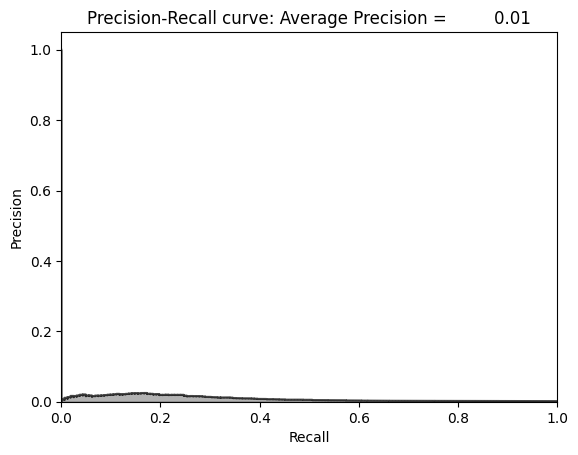

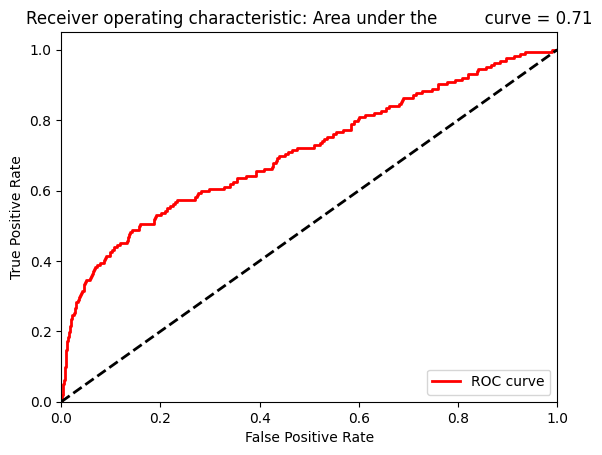

Epoch 1/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.2417 - accuracy: 0.7420 - val_loss: 0.0375 - val_accuracy: 0.9274
Epoch 2/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0490 - accuracy: 0.9111 - val_loss: 0.0369 - val_accuracy: 0.9474
Epoch 3/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0476 - accuracy: 0.9157 - val_loss: 0.0391 - val_accuracy: 0.9501
Epoch 4/10
5964/5964 [==============================] - 45s 8ms/step - loss: 0.0467 - accuracy: 0.9225 - val_loss: 0.0372 - val_accuracy: 0.9440
Epoch 5/10
5964/5964 [==============================] - 33s 6ms/step - loss: 0.0481 - accuracy: 0.9183 - val_loss: 0.0373 - val_accuracy: 0.9446
Epoch 6/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.0478 - accuracy: 0.9200 - val_loss: 0.0385 - val_accuracy: 0.9323
Epoch 7/10
5964/5964 [==============================] - 33s 6ms/step - loss: 0.0469 - accuracy: 0.9125 - val_loss: 0.0369 - val_ac

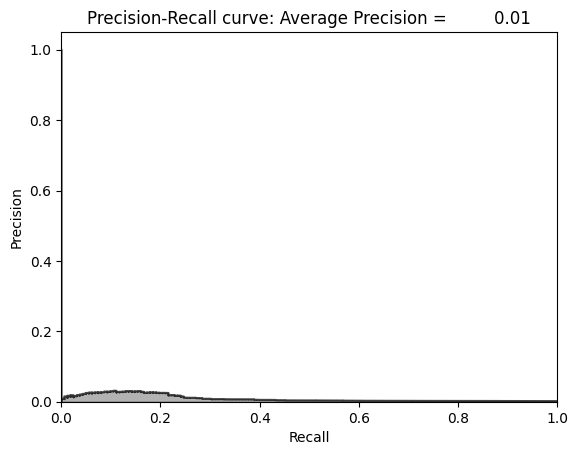

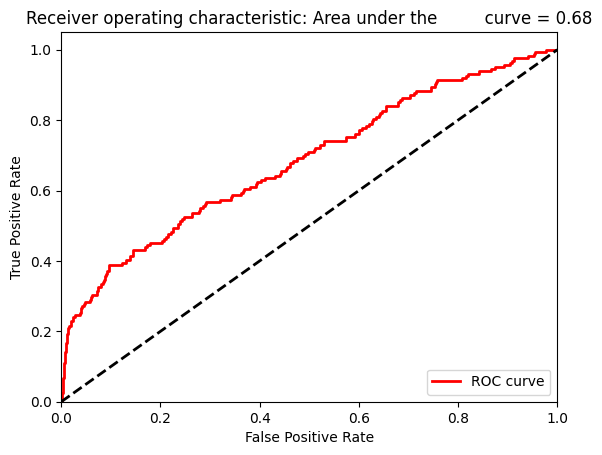

Epoch 1/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.1428 - accuracy: 0.7999 - val_loss: 0.0366 - val_accuracy: 0.9068
Epoch 2/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0497 - accuracy: 0.9021 - val_loss: 0.0369 - val_accuracy: 0.9338
Epoch 3/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0484 - accuracy: 0.9106 - val_loss: 0.0369 - val_accuracy: 0.9515
Epoch 4/10
5964/5964 [==============================] - 33s 6ms/step - loss: 0.0473 - accuracy: 0.9185 - val_loss: 0.0371 - val_accuracy: 0.9593
Epoch 5/10
5964/5964 [==============================] - 41s 7ms/step - loss: 0.0474 - accuracy: 0.9202 - val_loss: 0.0367 - val_accuracy: 0.9324
Epoch 6/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0474 - accuracy: 0.9157 - val_loss: 0.0368 - val_accuracy: 0.9316
Epoch 7/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0477 - accuracy: 0.9177 - val_loss: 0.0367 - val_ac

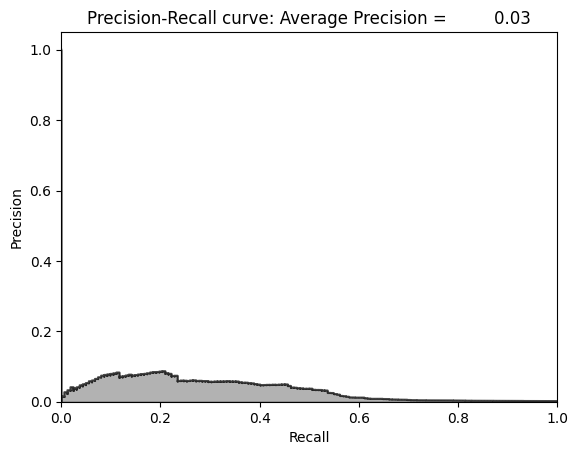

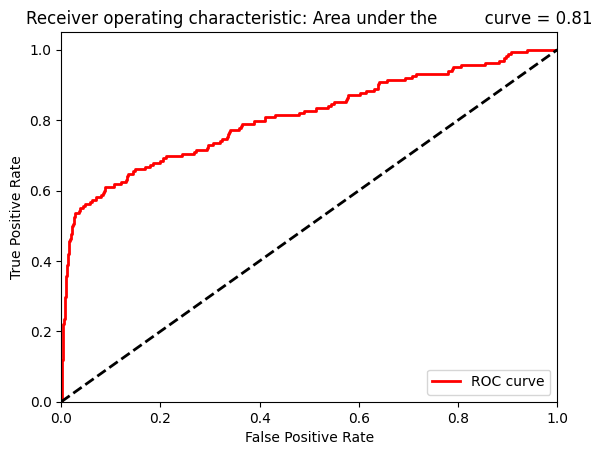

Epoch 1/10
5964/5964 [==============================] - 35s 6ms/step - loss: 0.1262 - accuracy: 0.8089 - val_loss: 0.0343 - val_accuracy: 0.9012
Epoch 2/10
5964/5964 [==============================] - 35s 6ms/step - loss: 0.0465 - accuracy: 0.8883 - val_loss: 0.0339 - val_accuracy: 0.9268
Epoch 3/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0467 - accuracy: 0.8940 - val_loss: 0.0341 - val_accuracy: 0.9475
Epoch 4/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0477 - accuracy: 0.9096 - val_loss: 0.0344 - val_accuracy: 0.9463
Epoch 5/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0447 - accuracy: 0.9142 - val_loss: 0.0337 - val_accuracy: 0.9578
Epoch 6/10
5964/5964 [==============================] - 33s 5ms/step - loss: 0.0446 - accuracy: 0.9168 - val_loss: 0.0339 - val_accuracy: 0.9525
Epoch 7/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0437 - accuracy: 0.9177 - val_loss: 0.0337 - val_ac

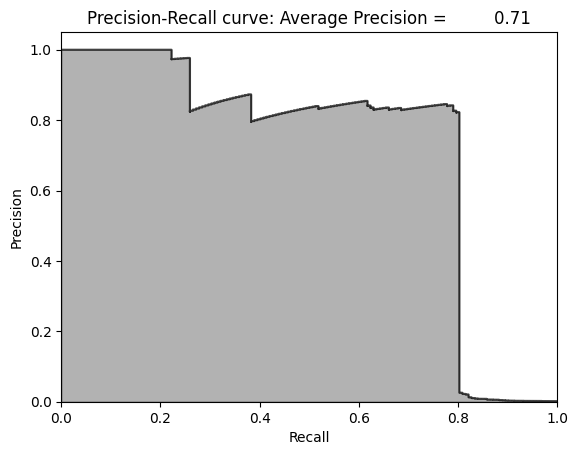

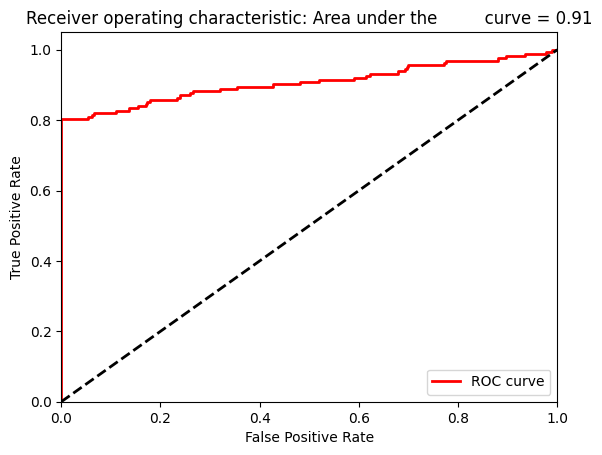

Epoch 1/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.1273 - accuracy: 0.8227 - val_loss: 0.0352 - val_accuracy: 0.9337
Epoch 2/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.0477 - accuracy: 0.9118 - val_loss: 0.0359 - val_accuracy: 0.9283
Epoch 3/10
5964/5964 [==============================] - 42s 7ms/step - loss: 0.0467 - accuracy: 0.9070 - val_loss: 0.0359 - val_accuracy: 0.9393
Epoch 4/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0476 - accuracy: 0.9123 - val_loss: 0.0361 - val_accuracy: 0.9428
Epoch 5/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.0470 - accuracy: 0.9120 - val_loss: 0.0366 - val_accuracy: 0.9405
Epoch 6/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0473 - accuracy: 0.9103 - val_loss: 0.0366 - val_accuracy: 0.9479
Epoch 7/10
5964/5964 [==============================] - 35s 6ms/step - loss: 0.0474 - accuracy: 0.9184 - val_loss: 0.0365 - val_ac

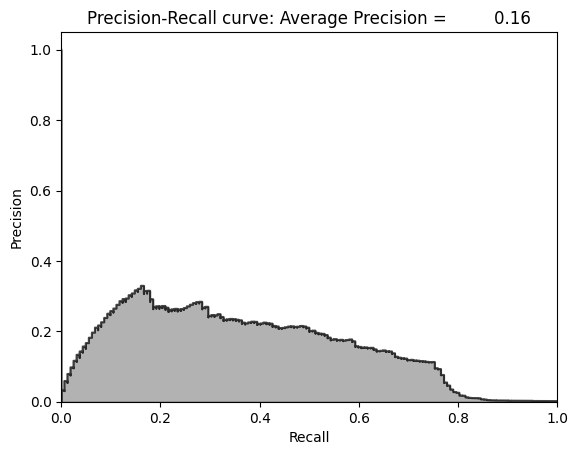

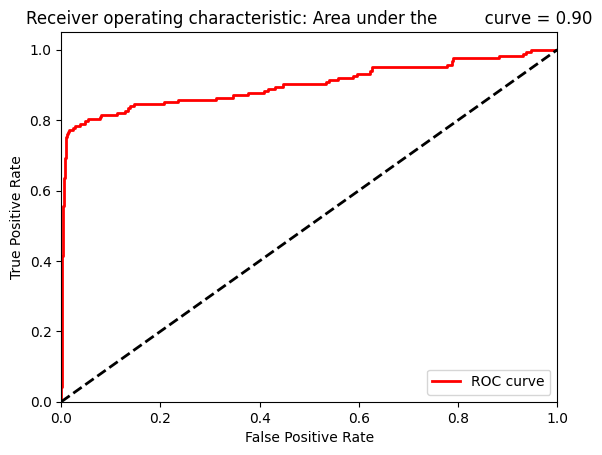

Epoch 1/10
5964/5964 [==============================] - 44s 7ms/step - loss: 0.1477 - accuracy: 0.8029 - val_loss: 0.0384 - val_accuracy: 0.8970
Epoch 2/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0469 - accuracy: 0.8937 - val_loss: 0.0346 - val_accuracy: 0.9258
Epoch 3/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0456 - accuracy: 0.9072 - val_loss: 0.0339 - val_accuracy: 0.9481
Epoch 4/10
5964/5964 [==============================] - 35s 6ms/step - loss: 0.0464 - accuracy: 0.9135 - val_loss: 0.0343 - val_accuracy: 0.9502
Epoch 5/10
5964/5964 [==============================] - 32s 5ms/step - loss: 0.0444 - accuracy: 0.9156 - val_loss: 0.0381 - val_accuracy: 0.9439
Epoch 6/10
5964/5964 [==============================] - 34s 6ms/step - loss: 0.0464 - accuracy: 0.9133 - val_loss: 0.0339 - val_accuracy: 0.9539
Epoch 7/10
5964/5964 [==============================] - 43s 7ms/step - loss: 0.0458 - accuracy: 0.9126 - val_loss: 0.0340 - val_ac

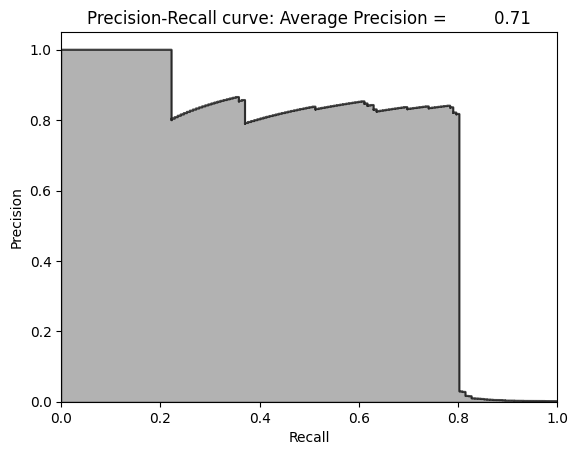

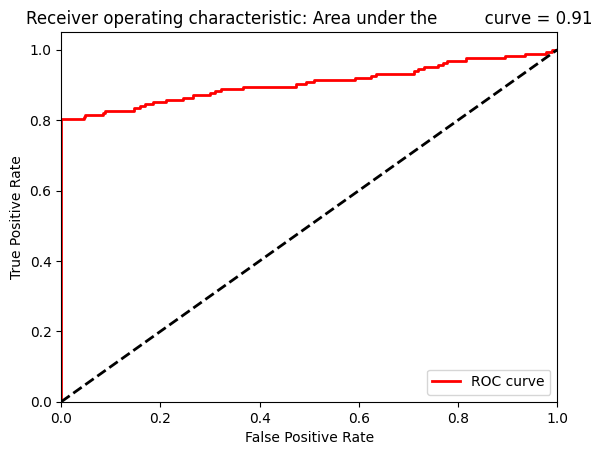

Mean average precision over 10 runs:  0.24050940544625124


[0.009282836304800465,
 0.048341040722309776,
 0.6975541611667639,
 0.01801157999565903,
 0.008808107932015325,
 0.008864519146219628,
 0.033673372807321904,
 0.7144042541644802,
 0.15927644804300953,
 0.7068777341799327]

In [10]:
# 선형 활성화 함수를 가진 2-계층 노이즈 제거 과소완전 오토인코더(은닉층 27개 노드)
# 10번 실행 - 평균 정밀도의 평균 계산
test_scores = []

noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
 np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape)

for i in range(0,10):
    # 신경망 API 호출
    model = Sequential()

    # 선형 활성화 함수를 가진 27개 노드를 가진 은닉층 생성
    model.add(Dense(units=27, activation='linear', input_dim=28))

    # 28개 노드를 가진 출력층 생성
    model.add(Dense(units=28, activation='linear'))

    # 모델 컴파일
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    # 모델 훈련
    num_epochs = 10
    batch_size = 32

    history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_train_AE, X_train_AE),
                        verbose=1)

        # 테스트 셋에 대한 평가
    predictions = model.predict(X_test_AE_noisy, verbose=1)
    anomalyScoresAE = anomalyScores(X_test, predictions)
    preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
    test_scores.append(avgPrecision)
    model.reset_states()

print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

In [11]:
# 결과
print("Mean average precision over 10 runs: ", np.mean(test_scores))
print("Coefficient of variation over 10 runs: ", np.std(test_scores)/ \
                                                np.mean(test_scores))
test_scores

Mean average precision over 10 runs:  0.24050940544625124
Coefficient of variation over 10 runs:  1.2799063642679525


[0.009282836304800465,
 0.048341040722309776,
 0.6975541611667639,
 0.01801157999565903,
 0.008808107932015325,
 0.008864519146219628,
 0.033673372807321904,
 0.7144042541644802,
 0.15927644804300953,
 0.7068777341799327]